# Non stationary Ornstein Uhlenbeck in 2D (Fokker-Planck Equation) with RAR sampling & SPINNs

We want to estimate the solution $u(t,\mathbf{x})$ of

$$
-\sum_{i=1}^2\frac{\partial}{\partial \mathbf{x}}
         \left[(\alpha(\mu - \mathbf{x}))u(t,\mathbf{x})\right] +
         \sum_{i=1}^2\sum_{j=1}^2\frac{\partial^2}{\partial x_i \partial x_j}              
         \left[\frac{\sigma^2}{2}u(t,\mathbf{x})\right]=                                   
         \frac{\partial}
         {\partial t}u(t,\mathbf{x})
 $$

The notebook is divided in two main sections:

1) Solving with PINNs and RAR

2) Solving with SPINNs

3) Conclusion

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


Import our package

In [2]:
import jinns


Import other dependencies

In [3]:
import jax
from jax import random, vmap
import jax.numpy as jnp
import equinox as eqx
from functools import partial
import time
import matplotlib.pyplot as plt

key = random.PRNGKey(2)
key, subkey = random.split(key)


2024-11-17 16:44:23.874132: W external/xla/xla/service/gpu/nvptx_compiler.cc:893] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version 12.3.107. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Create the neural network architecture for the PINN with `equinox`. Note that we will use the same architecture for the 3 populations.

In [4]:
eqx_list = (
    (eqx.nn.Linear, 3, 30),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 30, 30),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 30, 30),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 30, 1),
    (jnp.exp,)
)
key, subkey = random.split(key)
u, init_nn_params = jinns.utils.create_PINN(subkey, eqx_list, "nonstatio_PDE", 2)


Create the DataGenerator object. In this notebook we illustrate an example using the Residual Adaptative Refinement algorithm for improved collocation points for PINN training. The reference is _DeepXDE: A deep learning library for solving differential equations_, L. Lu, SIAM Review, 2021.

Thus we first define an additional dictionary of parameters for the RAR algorithm, it will be passed at the initialization of the DataGenerator:

In [5]:
rar_parameters = {
    'start_iter':1000, # the gradient step at which RAR algo starts (enables a burn in period)
    'update_every': 500, # nb of gradient steps between two RAR procedures
    'sample_size': 22, # the number of new candidates time points
    'selected_sample_size': 5, # the number of selected times collocation points from the sample, to join the dataset.
}
n_start  = 500 # the initial number of  collocation points at beginning

Therefore, the set of parameters above gives the following number collocation points used (DataGenerator's `domain` attributes). 
- 505 at iterations 0 to 999
- 510 at iterations 1000 to 1499
- 515 at iterations 1500 to 1999
- ...

User can play with the `selected_sample_size` entry of `rar_parameters` to add more collocation points in the non-stationnary cases.

__Note:__ If given too many iterations, the RAR algorithm can require a number of collocation points that will be larger that `n`. In order to prevent an undefined behaviour, when such case is attained RAR updates will not happen anymore. This is because JAX do not allow to have dynamically shaped Arrays.

__Note: The PINN approach would work as good without RAR sampling in this simple approach, we would thus save computational efforts__

In [6]:
n = 2500
nb = None
ni = 200
xmin = -3
xmax = 3
ymin = -3
ymax = 3
tmin = 0
tmax = 1
method="uniform"

key, subkey = random.split(key)
train_data = jinns.data.CubicMeshPDENonStatio(
    key=subkey,
    n=n,
    nb=nb,
    ni=ni,
    dim=2,
    min_pts=(xmin, ymin),
    max_pts=(xmax, ymax),
    tmin=tmin,
    tmax=tmax,
    method=method,
    rar_parameters=rar_parameters,
    n_start=n_start,
)


## Model parameters

In [7]:
# true solution N(0,1)
sigma = 0.5 * jnp.ones((2))
alpha = .5 * jnp.ones((2))
mu = jnp.zeros((2))

Tmax = 5


In our problem we know the analytical stationary solution

In [8]:
from jax.scipy.stats import multivariate_normal

def u_statio(x):
    return multivariate_normal.pdf(x, mean=mu, cov=jnp.diag((sigma/jnp.sqrt(2*alpha)) ** 2))

vectorized_u_statio = vmap(u_statio, (0), 0)


In [9]:
init_params = jinns.parameters.Params(
    nn_params=init_nn_params,
    eq_params={
        "sigma":sigma,
        "alpha":alpha,
        "mu":mu
    }
)


## Set up the initial condition

In [10]:
# Initial law at t=0
u0 = u_statio

# Another init
# TODO : implement other init
def u0(x):
    return multivariate_normal.pdf(x, mean=jnp.array([1, 1]), cov=0.1 * jnp.eye(2))

vectorized_u0 = vmap(u0, (0), 0)


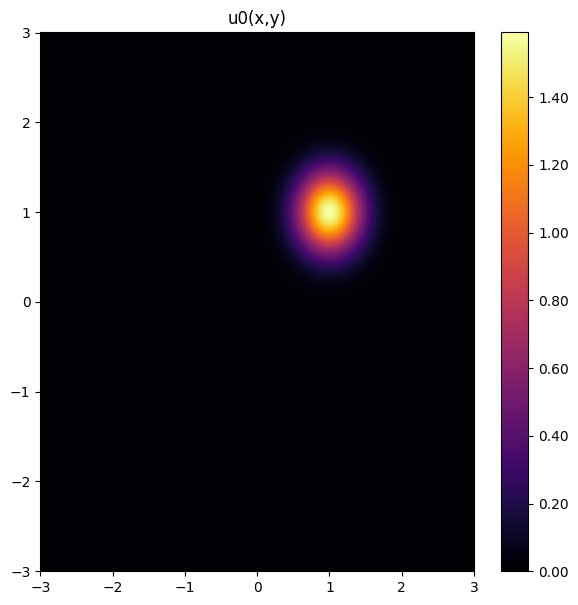

In [11]:
nx, ny = 1000, 1000
val_xy_data = [jnp.linspace(xmin, xmax, nx),
               jnp.linspace(ymin, ymax, ny)
              ]

jinns.plot.plot2d(
    fun=u0,
    xy_data=val_xy_data,
    title="u0(x,y)"
)


## Loss construction

We decide to provide the set of points upon which the normalization constant will be computed

In [12]:
int_xmin, int_xmax = -3, 3
int_ymin, int_ymax = -3, 3

n_samples = int(1e3)
int_length = (int_xmax - int_xmin) * (int_ymax - int_ymin)
key, subkey1, subkey2 = random.split(key, 3)
mc_samples = jnp.concatenate(
    [
        random.uniform(
            subkey1, shape = (n_samples, 1), minval=int_xmin, maxval=int_xmax
        ),
        random.uniform(
            subkey2, shape = (n_samples, 1), minval=int_ymin, maxval=int_ymax
        )
    ],
    axis=-1
)


In [13]:
OU_fpe_non_statio_2D_loss = jinns.loss.OU_FPENonStatioLoss2D(Tmax=Tmax)


In [14]:
loss_weights = jinns.loss.LossWeightsPDENonStatio(
    dyn_loss=1,
    initial_condition=1 * Tmax,
    norm_loss=1 * Tmax
)

loss = jinns.loss.LossPDENonStatio(
    u=u,
    loss_weights=loss_weights,
    dynamic_loss=OU_fpe_non_statio_2D_loss,
    initial_condition_fun=u0,
    norm_int_length=(int_xmax - int_xmin) * (int_ymax - int_ymin),
    norm_samples=mc_samples,
    params=init_params
)


/home/hugo/Documents/recherche/pinn/gitlab/jinns/loss/_LossPDE.py:177: UserWarning: Missing boundary function or no boundary condition.Boundary function is thus ignored.
  warnings.warn(


In [15]:
losses_and_grad = jax.value_and_grad(loss.evaluate, 0, has_aux=True)
losses, grads = losses_and_grad(
    init_params,
    batch = train_data.get_batch()[1]
)


l_tot, d = losses
print(f"total loss: {l_tot:.2f}")
print(f"Individual losses: { {key: f'{val:.2f}' for key, val in d.items()} }")


total loss: 8229.37
Individual losses: {'boundary_loss': '0.00', 'dyn_loss': '35.53', 'initial_condition': '6.80', 'norm_loss': '8187.04', 'observations': '0.00'}


## Learning the neural network parameters
The learning process here consider known equation parameters `eq_params`. We thus only update `nn_params`

In [16]:
# Optimizer
import optax

tx = optax.adamw(learning_rate=1e-3)


In [17]:
n_iter = 50000


In [18]:
params = init_params


We are performing RAR sampling scheme, let's see the distribution fo the collocation points before the start of the training.

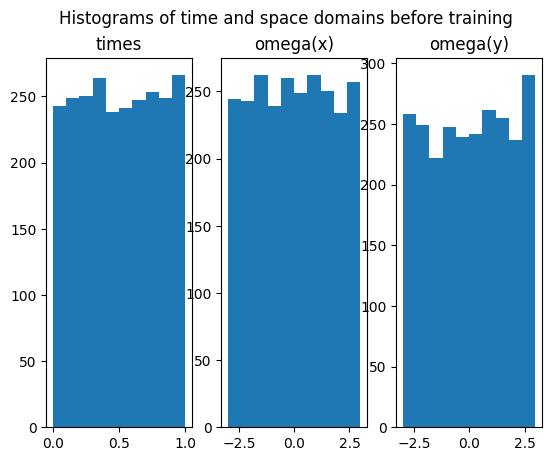

In [19]:
fig, ax = plt.subplots(1, 3)
ax[0].hist(train_data.domain[:, 0].flatten())
ax[0].set_title('times')
ax[1].hist(train_data.domain[:, 1].flatten())
ax[1].set_title('omega(x)')
ax[2].hist(train_data.domain[:, 2].flatten())
ax[2].set_title('omega(y)')
fig.suptitle('Histograms of time and space domains before training')
plt.savefig("hist_data_before.pdf")
plt.show()


In [20]:
key, subkey = random.split(key, 2)
params, total_loss_list, loss_by_term_dict, train_data, loss, _, _ , _, _ = jinns.solve(
    init_params=params,
    data=train_data,
    optimizer=tx,
    loss=loss,
    n_iter=n_iter
)


Compilation took
 7.331557035446167 

[train] Iteration 0: loss value = 8229.373046875
[train] Iteration 1000: loss value = 0.18753540515899658
[train] Iteration 2000: loss value = 0.1176738291978836
[train] Iteration 3000: loss value = 0.1073598712682724
[train] Iteration 4000: loss value = 0.09509041905403137
[train] Iteration 5000: loss value = 0.0825364962220192
[train] Iteration 6000: loss value = 0.0721798688173294
[train] Iteration 7000: loss value = 0.06636429578065872
[train] Iteration 8000: loss value = 0.06444961577653885
[train] Iteration 9000: loss value = 0.06334780901670456
[train] Iteration 10000: loss value = 0.06210724264383316
[train] Iteration 11000: loss value = 0.0607522577047348
[train] Iteration 12000: loss value = 0.05945876985788345
[train] Iteration 13000: loss value = 0.058344483375549316
[train] Iteration 14000: loss value = 0.05743587762117386
[train] Iteration 15000: loss value = 0.05658558011054993
[train] Iteration 16000: loss value = 0.042889364063739

In the next figure, we see the distribution fo the collocation points after the end of the training. We see that the new points are preferentially added on the borders and around the origin in the upper right quadrant. This could be expected since we expected that those are the collocation points where most things actually happen.

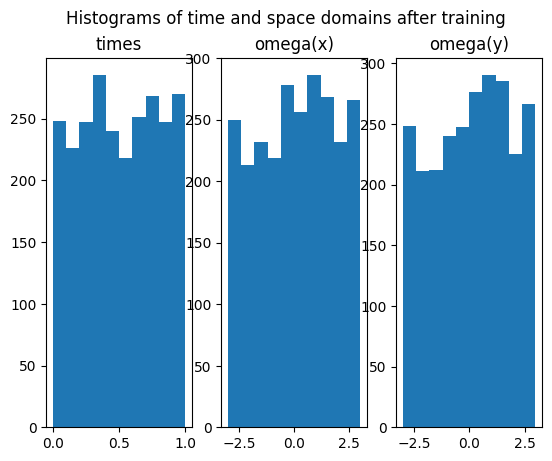

In [21]:
fig, ax = plt.subplots(1, 3)
ax[0].hist(train_data.domain[:, 0])
ax[0].set_title('times')
ax[1].hist(train_data.domain[:, 1].flatten())
ax[1].set_title('omega(x)')
ax[2].hist(train_data.domain[:, 2].flatten())
ax[2].set_title('omega(y)')
fig.suptitle('Histograms of time and space domains after training')
plt.savefig("hist_data_after.pdf")
plt.show()


## Results

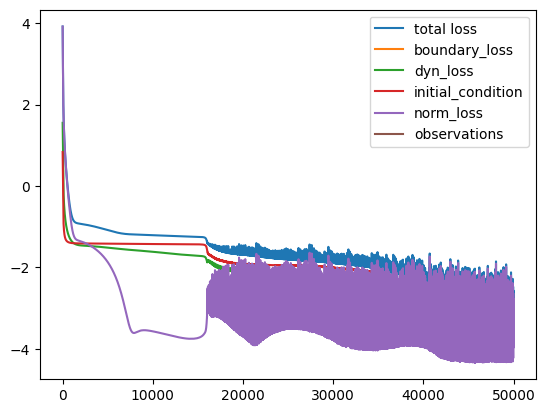

In [22]:
plt.plot(jnp.log10(total_loss_list), label="total loss")
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.legend()
plt.show();


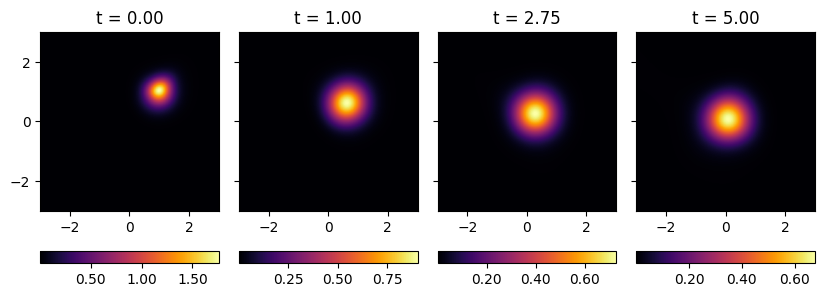

In [23]:
times = [0, 0.2, 0.55, 1] # times in the rescaled time susescale
u_est = lambda t_x:u(t_x, params.nn_params)
jinns.plot.plot2d(
    fun=u_est,
    xy_data=val_xy_data,
    times = times,
    Tmax=Tmax,
    title="u0(x,y)",
    figsize=(10, 10*len(times))
)


## 2) Separable PINNs
In this section, we run experiments in the same context but with [Separable PINNs](https://openreview.net/pdf?id=dEySGIcDnI).

In [24]:
key = jax.random.PRNGKey(2)

In [25]:
d = 3
r = 256
eqx_list = (
    (eqx.nn.Linear, 1, 128),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 128, 128),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 128, 128),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 128, r),
)
key, subkey = random.split(key)

In [26]:
u, init_nn_params = jinns.utils.create_SPINN(subkey, d, r, eqx_list, "nonstatio_PDE")

In [27]:
n = 5000
nb = None
ni = 200
xmin = -3
xmax = 3
ymin = -3
ymax = 3
tmin = 0
tmax = 1
method="uniform"

key, subkey = random.split(key)
train_data = jinns.data.CubicMeshPDENonStatio(
    key=subkey,
    n=n,
    nb=nb,
    ni=ni,
    dim=2,
    min_pts=(xmin, ymin),
    max_pts=(xmax, ymax),
    domain_batch_size=32,
    initial_batch_size=32,
    tmin=tmin,
    tmax=tmax,
    method=method
)

In [28]:
init_params = jinns.parameters.Params(
    nn_params=init_nn_params,
    eq_params={
        "sigma":sigma,
        "alpha":alpha,
        "mu":mu
    }
)

In [29]:
int_xmin, int_xmax = -3, 3
int_ymin, int_ymax = -3, 3

n_samples = 32
int_length = (int_xmax - int_xmin) * (int_ymax - int_ymin)
key, subkey1, subkey2 = random.split(key, 3)
mc_samples = jnp.concatenate(
    [
        random.uniform(
            subkey1, shape = (n_samples, 1), minval=int_xmin, maxval=int_xmax
        ),
        random.uniform(
            subkey2, shape = (n_samples, 1), minval=int_ymin, maxval=int_ymax
        )
    ],
    axis=-1
)

In [30]:
loss_weights = jinns.loss.LossWeightsPDENonStatio(
    dyn_loss=1,
    initial_condition=1 * Tmax,
    norm_loss=1 * Tmax
)
OU_fpe_non_statio_2D_loss = jinns.loss.OU_FPENonStatioLoss2D(Tmax=Tmax)

loss = jinns.loss.LossPDENonStatio(
    u=u,
    loss_weights=loss_weights,
    dynamic_loss=OU_fpe_non_statio_2D_loss,
    initial_condition_fun=u0,
    norm_int_length=(int_xmax - int_xmin) * (int_ymax - int_ymin),
    norm_samples=mc_samples,
    params=init_params
)


/home/hugo/Documents/recherche/pinn/gitlab/jinns/loss/_LossPDE.py:177: UserWarning: Missing boundary function or no boundary condition.Boundary function is thus ignored.
  warnings.warn(


In [31]:
params = init_params

In [32]:
import optax
tx = optax.adamw(learning_rate=1e-4)
n_iter = 50000
key, subkey = random.split(key, 2)
params, total_loss_list, loss_by_term_dict, train_data, loss, _, _ , _, _ = jinns.solve(
    init_params=params,
    data=train_data,
    optimizer=tx,
    loss=loss,
    n_iter=n_iter
)


Compilation took
 13.696454286575317 

[train] Iteration 0: loss value = 4.233202934265137
[train] Iteration 1000: loss value = 0.0980076938867569
[train] Iteration 2000: loss value = 0.09151782840490341
[train] Iteration 3000: loss value = 0.043308138847351074
[train] Iteration 4000: loss value = 0.033935826271772385
[train] Iteration 5000: loss value = 0.032171741127967834
[train] Iteration 6000: loss value = 0.021552959457039833
[train] Iteration 7000: loss value = 0.013673398643732071
[train] Iteration 8000: loss value = 0.007197866216301918
[train] Iteration 9000: loss value = 0.009655427187681198
[train] Iteration 10000: loss value = 0.008708847686648369
[train] Iteration 11000: loss value = 0.004313863813877106
[train] Iteration 12000: loss value = 0.004635334946215153
[train] Iteration 13000: loss value = 0.004907514899969101
[train] Iteration 14000: loss value = 0.003136567771434784
[train] Iteration 15000: loss value = 0.0038782258052378893
[train] Iteration 16000: loss valu

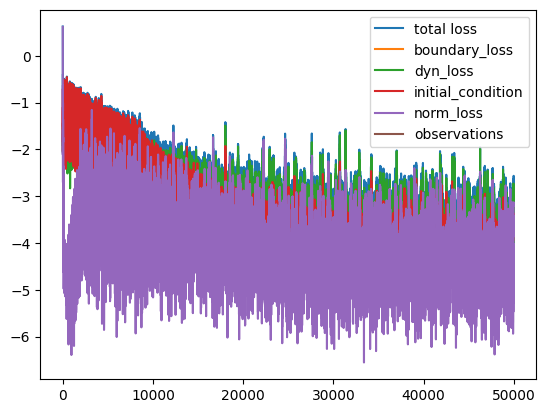

In [33]:
plt.plot(jnp.log10(total_loss_list), label="total loss")
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.legend()
plt.show();


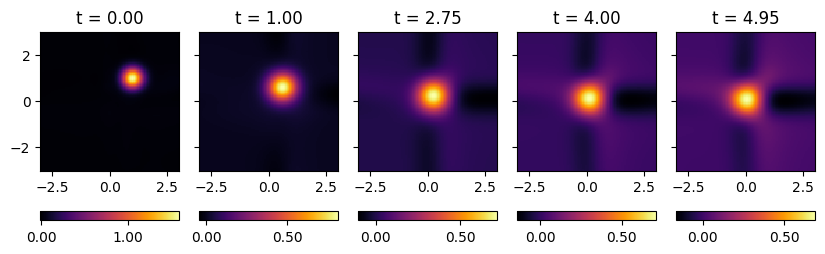

In [34]:
nx, ny = 100, 100 # Set less validation points for SPINN otherwise GPU memory explodes
val_xy_data = [jnp.linspace(xmin, xmax, nx),
               jnp.linspace(ymin, ymax, ny)
              ]


times = [0, 0.2, 0.55, 0.8, 0.99] # times in the rescaled time susescale
u_est = lambda t_x: u(t_x, params.nn_params)
jinns.plot.plot2d(
    fun=u_est,
    xy_data=val_xy_data,
    times = times,
    Tmax=Tmax,
    title="u0(x,y)",
    figsize=(10, 10*len(times)),
    spinn=True
)


## 3) Conclusion

We solved this 2D non-stationary Fokker-Planck PDE using both PINNs and SPINNs. PINNs end up with a more accurate estimation. A speed advantage goes to SPINN but the PINN offers a more accurate estimation in fine. Note that, in this particular example, using a PINN without RAR sampling also works well. Note that the SPINN setting should be fine-tuned.